## Without Condition

In [9]:
from keras.datasets.fashion_mnist import load_data
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


In [13]:
testX[0].shape

(28, 28)

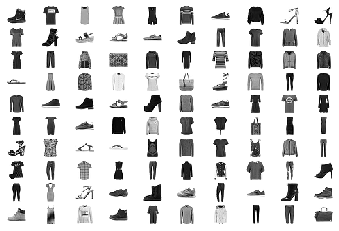

In [12]:
# plot images from the training dataset
from matplotlib import pyplot
for i in range(100):
	# define subplot
	pyplot.subplot(10, 10, 1 + i)
	# turn off axis
	pyplot.axis('off')
	# plot raw pixel data
	pyplot.imshow(trainX[i], cmap='gray_r')
pyplot.show()

In [5]:

# example of training an unconditional gan on the fashion mnist dataset
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# generate
	model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# load fashion mnist images
def load_real_samples():
	# load dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n_samples, 1))
	return X, y

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
	# save the generator model
	g_model.save('generator.h5')

# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)


>1, 1/234, d1=0.725, d2=0.696 g=0.691
>1, 2/234, d1=0.643, d2=0.701 g=0.686
>1, 3/234, d1=0.575, d2=0.709 g=0.678
>1, 4/234, d1=0.517, d2=0.722 g=0.668
>1, 5/234, d1=0.456, d2=0.741 g=0.654
>1, 6/234, d1=0.407, d2=0.764 g=0.637
>1, 7/234, d1=0.374, d2=0.791 g=0.623
>1, 8/234, d1=0.326, d2=0.816 g=0.616
>1, 9/234, d1=0.314, d2=0.824 g=0.620
>1, 10/234, d1=0.297, d2=0.820 g=0.648
>1, 11/234, d1=0.296, d2=0.778 g=0.710
>1, 12/234, d1=0.287, d2=0.682 g=0.818
>1, 13/234, d1=0.335, d2=0.587 g=0.935
>1, 14/234, d1=0.359, d2=0.508 g=1.050
>1, 15/234, d1=0.319, d2=0.456 g=1.110
>1, 16/234, d1=0.362, d2=0.463 g=1.076
>1, 17/234, d1=0.312, d2=0.527 g=0.966
>1, 18/234, d1=0.343, d2=0.620 g=0.825
>1, 19/234, d1=0.332, d2=0.708 g=0.724
>1, 20/234, d1=0.239, d2=0.765 g=0.683
>1, 21/234, d1=0.249, d2=0.784 g=0.677
>1, 22/234, d1=0.237, d2=0.767 g=0.702
>1, 23/234, d1=0.204, d2=0.753 g=0.722
>1, 24/234, d1=0.192, d2=0.770 g=0.710
>1, 25/234, d1=0.173, d2=0.795 g=0.697
>1, 26/234, d1=0.152, d2=0.798 g=0

>1, 201/234, d1=0.798, d2=0.753 g=0.737
>1, 202/234, d1=0.788, d2=0.734 g=0.747
>1, 203/234, d1=0.795, d2=0.703 g=0.766
>1, 204/234, d1=0.796, d2=0.706 g=0.794
>1, 205/234, d1=0.809, d2=0.704 g=0.783
>1, 206/234, d1=0.790, d2=0.676 g=0.783
>1, 207/234, d1=0.777, d2=0.711 g=0.778
>1, 208/234, d1=0.757, d2=0.692 g=0.781
>1, 209/234, d1=0.794, d2=0.709 g=0.766
>1, 210/234, d1=0.742, d2=0.713 g=0.758
>1, 211/234, d1=0.776, d2=0.698 g=0.775
>1, 212/234, d1=0.766, d2=0.701 g=0.771
>1, 213/234, d1=0.767, d2=0.675 g=0.788
>1, 214/234, d1=0.751, d2=0.656 g=0.779
>1, 215/234, d1=0.731, d2=0.663 g=0.791
>1, 216/234, d1=0.723, d2=0.661 g=0.806
>1, 217/234, d1=0.707, d2=0.656 g=0.806
>1, 218/234, d1=0.718, d2=0.646 g=0.820
>1, 219/234, d1=0.709, d2=0.667 g=0.806
>1, 220/234, d1=0.693, d2=0.675 g=0.788
>1, 221/234, d1=0.700, d2=0.673 g=0.782
>1, 222/234, d1=0.707, d2=0.687 g=0.781
>1, 223/234, d1=0.752, d2=0.704 g=0.753
>1, 224/234, d1=0.736, d2=0.714 g=0.732
>1, 225/234, d1=0.734, d2=0.734 g=0.730


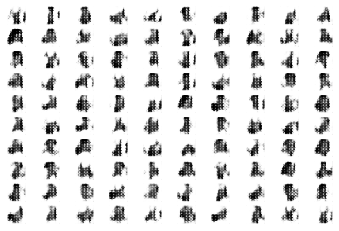

In [7]:


# example of loading the generator model and generating images
from tensorflow.keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# create and save a plot of generated images (reversed grayscale)
def show_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()
 
# load model
model = load_model('generator.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# plot the result
show_plot(X, 10)

## With Condition

In [22]:


# example of training an conditional gan on the fashion mnist dataset
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Concatenate
 
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# scale up to image dimensions with linear activation
	n_nodes = in_shape[0] * in_shape[1]
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((in_shape[0], in_shape[1], 1))(li)
	# image input
	in_image = Input(shape=in_shape)
	# concat label as a channel
	merge = Concatenate()([in_image, li])
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)
	# define model
	model = Model([in_image, in_label], out_layer)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model
 
# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# linear multiplication
	n_nodes = 7 * 7
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((7, 7, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((7, 7, 128))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
	# upsample to 14x14
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 28x28
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
 
# load fashion mnist images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return [X, trainy]
 
# # select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1, n_batch=256):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
			# generate 'fake' examples
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
			# prepare points in latent space as input for the generator
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
	# save the generator model
	g_model.save('cgan_generator.h5')
 
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

>1, 1/234, d1=0.709, d2=0.695 g=0.691
>1, 2/234, d1=0.635, d2=0.700 g=0.686
>1, 3/234, d1=0.586, d2=0.710 g=0.678
>1, 4/234, d1=0.522, d2=0.724 g=0.665
>1, 5/234, d1=0.473, d2=0.744 g=0.649
>1, 6/234, d1=0.420, d2=0.768 g=0.631
>1, 7/234, d1=0.383, d2=0.801 g=0.616
>1, 8/234, d1=0.351, d2=0.823 g=0.607
>1, 9/234, d1=0.339, d2=0.827 g=0.615
>1, 10/234, d1=0.326, d2=0.806 g=0.647
>1, 11/234, d1=0.324, d2=0.763 g=0.704
>1, 12/234, d1=0.350, d2=0.691 g=0.783
>1, 13/234, d1=0.346, d2=0.618 g=0.875
>1, 14/234, d1=0.333, d2=0.548 g=0.953
>1, 15/234, d1=0.339, d2=0.513 g=0.993
>1, 16/234, d1=0.342, d2=0.531 g=0.963
>1, 17/234, d1=0.353, d2=0.572 g=0.889
>1, 18/234, d1=0.328, d2=0.649 g=0.800
>1, 19/234, d1=0.287, d2=0.748 g=0.718
>1, 20/234, d1=0.256, d2=0.811 g=0.684
>1, 21/234, d1=0.252, d2=0.823 g=0.674
>1, 22/234, d1=0.221, d2=0.840 g=0.671
>1, 23/234, d1=0.215, d2=0.857 g=0.669
>1, 24/234, d1=0.190, d2=0.844 g=0.689
>1, 25/234, d1=0.178, d2=0.781 g=0.765
>1, 26/234, d1=0.158, d2=0.654 g=0

>1, 201/234, d1=0.713, d2=0.636 g=0.887
>1, 202/234, d1=0.733, d2=0.655 g=0.876
>1, 203/234, d1=0.709, d2=0.653 g=0.857
>1, 204/234, d1=0.694, d2=0.649 g=0.880
>1, 205/234, d1=0.704, d2=0.640 g=0.864
>1, 206/234, d1=0.673, d2=0.630 g=0.871
>1, 207/234, d1=0.711, d2=0.626 g=0.878
>1, 208/234, d1=0.710, d2=0.638 g=0.888
>1, 209/234, d1=0.701, d2=0.635 g=0.870
>1, 210/234, d1=0.689, d2=0.653 g=0.853
>1, 211/234, d1=0.686, d2=0.681 g=0.851
>1, 212/234, d1=0.660, d2=0.662 g=0.850
>1, 213/234, d1=0.669, d2=0.678 g=0.829
>1, 214/234, d1=0.647, d2=0.656 g=0.836
>1, 215/234, d1=0.671, d2=0.659 g=0.818
>1, 216/234, d1=0.654, d2=0.676 g=0.828
>1, 217/234, d1=0.667, d2=0.676 g=0.825
>1, 218/234, d1=0.639, d2=0.666 g=0.810
>1, 219/234, d1=0.655, d2=0.714 g=0.800
>1, 220/234, d1=0.669, d2=0.708 g=0.795
>1, 221/234, d1=0.648, d2=0.717 g=0.782
>1, 222/234, d1=0.702, d2=0.759 g=0.764
>1, 223/234, d1=0.668, d2=0.752 g=0.760
>1, 224/234, d1=0.667, d2=0.762 g=0.768
>1, 225/234, d1=0.697, d2=0.738 g=0.778


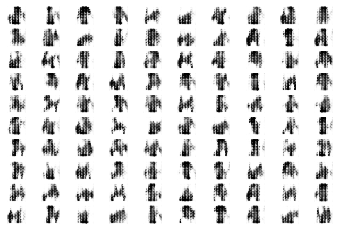

In [25]:


# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.models import load_model
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]
 
# create and save a plot of generated images
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()
 
# load model
model = load_model('cgan_generator.h5')
# generate images
latent_points, labels = generate_latent_points(100, 100)
# specify labels
labels = asarray([x for _ in range(10) for x in range(10)])
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 10)